# Plume Analysis Walkthrough

This notebook provides a step-by-step guide to understanding the `plumes_analyzer.py` script. We will walk through the process of calculating methane emission rates and their uncertainties from satellite-derived concentration maps. Each step is accompanied by explanations and the corresponding mathematical formulations.

## 1. Setup and Imports

First, let's import the necessary libraries. We'll need `numpy` for numerical operations, `gdal` for raster data handling, `geopandas` for vector data (shapefiles), and `matplotlib` for plotting.

In [1]:

import os
import sys
from pathlib import Path
from datetime import datetime
import numpy as np
import math
from osgeo import gdal, ogr, osr
from pyproj import CRS
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

# Add the scripts directory to the python path to import the custom modules
NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT.parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from scripts import plumes_analyzer



## 2. Configuration and Case Selection

Multiple case studies can be queued just like in `matched_filter_demo_enmap.ipynb`. Define a dictionary of case-specific file paths and assumptions, pick `SELECTED_CASE`, and the notebook will wire up the matching concentration map, plume mask, and wind parameters automatically.


In [2]:
BASE_DIR = Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/')
PIPELINE_DEMO_DIR = BASE_DIR / 'notebooks' / 'outputs' / 'pipeline_demo'

PLUME_CASES = {
    'turkmenistan_plume': {
        'scene_subdir': 'turkmenistan_plume',
        'concentration_file': PIPELINE_DEMO_DIR / 'enmap' / 'turkmenistan_plume' / 'L1B_DT0000004147_002_20221002T074833Z_20221002T074837Z_MF.tif',
        'uncertainty_file': PIPELINE_DEMO_DIR / 'enmap' / 'turkmenistan_plume' / 'L1B_DT0000004147_002_20221002T074833Z_20221002T074837Z_MF_uncertainty.tif',
        'shapefile_path': PIPELINE_DEMO_DIR / 'enmap' / 'turkmenistan_plume' / 'turkmenistan_plume_2022102T074833.shp',
        'u10': 7.0,
        'sigma_u10': 1.5,
        'sensor_type': 'ENMAP',
        'gsd': 30,
    },
    'BuenosAires_20240112': {
        'scene_subdir': 'BuenosAires_20240112',
        'concentration_file': PIPELINE_DEMO_DIR / 'enmap' / 'BuenosAires_20240112' / 'L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_MF.tif',
        'uncertainty_file': PIPELINE_DEMO_DIR / 'enmap' / 'BuenosAires_20240112' / 'L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_MF_uncertainty.tif',
        'shapefile_path': BASE_DIR / 'case_studies_data' / 'BuenosAires_20240112' / 'EnMAP' / 'analysis_igarss2025' / '20240112T144653Z_002_V010501_20241021T060427Z_output' / 'enmap_plume_best.shp',
        'u10': 6.7,
        'sigma_u10': 1.0,
        'sensor_type': 'ENMAP',
        'gsd': 30,
    },
    'Turkmenistan_20240911': {
        'scene_subdir': 'Turkmenistan_20240911',
        'concentration_file': PIPELINE_DEMO_DIR / 'enmap' / 'Turkmenistan_20240911' / 'L1B_DT0000092488_001_20240911T075547Z_20240911T075552Z_MF.tif',
        'uncertainty_file': PIPELINE_DEMO_DIR / 'enmap' / 'Turkmenistan_20240911' / 'L1B_DT0000092488_001_20240911T075547Z_20240911T075552Z_MF_uncertainty.tif',
        'shapefile_path': BASE_DIR / 'case_studies_data' / 'Turkmenistan_20240911' / 'enmap' / 'igarss_2025_analysis' / '20240911T075547Z_output' / 'enmap_plume_1_igarss25.shp',
        'u10': 2.7,
        'sigma_u10': 1.0,
        'sensor_type': 'ENMAP',
        'gsd': 30,
    },
    'Ehrenberg_validation_prisma': {
        'scene_subdir': 'Ehrenberg_validation_prisma',
        'concentration_file': PIPELINE_DEMO_DIR / 'prisma' / 'Ehrenberg_validation_prisma' / 'PRS_L1_STD_OFFL_20211021182310_20211021182315_0001_MF_concentration.tif',
        'uncertainty_file': PIPELINE_DEMO_DIR / 'prisma' / 'Ehrenberg_validation_prisma' / 'PRS_L1_STD_OFFL_20211021182310_20211021182315_0001_MF_uncertainty.tif',
        'shapefile_path': PIPELINE_DEMO_DIR / 'prisma' / 'Ehrenberg_validation_prisma' / 'plume_hygas_full_column.shp',
        'u10': 3.7,
        'sigma_u10': 1.0,
        'sensor_type': 'ENMAP',
        'gsd': 30,
    },
}

SELECTED_CASE = 'Ehrenberg_validation_prisma'  # change to another key from PLUME_CASES to process a different plume
CASE_CONFIG = PLUME_CASES[SELECTED_CASE]

SCENE_SUBDIR = CASE_CONFIG['scene_subdir']
INPUT_DIR = CASE_CONFIG['concentration_file'].parent
OUTPUT_DIR = BASE_DIR / 'notebooks' / 'outputs' / 'plume_analysis_walkthrough' / SCENE_SUBDIR
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CONCENTRATION_FILE = CASE_CONFIG['concentration_file']
UNCERTAINTY_FILE = CASE_CONFIG['uncertainty_file']
SHAPEFILE_PATH = CASE_CONFIG['shapefile_path']
U10 = CASE_CONFIG['u10']
SIGMA_U10 = CASE_CONFIG['sigma_u10']
SENSOR_TYPE = CASE_CONFIG['sensor_type']

print(f'Selected case: {SELECTED_CASE}')
print(f'Concentration raster: {CONCENTRATION_FILE.name}')
print(f'Shapefile: {SHAPEFILE_PATH}')
print(f"U10: {U10:.2f} ± {SIGMA_U10:.2f} m/s (Sensor: {SENSOR_TYPE}, GSD: {CASE_CONFIG['gsd']} m)")


Selected case: Ehrenberg_validation_prisma
Concentration raster: PRS_L1_STD_OFFL_20211021182310_20211021182315_0001_MF_concentration.tif
Shapefile: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/prisma/Ehrenberg_validation_prisma/plume_hygas_full_column.shp
U10: 3.70 ± 1.00 m/s (Sensor: ENMAP, GSD: 30 m)



### Run Report Output

Set `SAVE_RUN_REPORT = True` to write a complete Markdown report (plus referenced figures) summarizing every measurement, plot, and intermediate result that is printed throughout the walkthrough.


In [3]:

SAVE_RUN_REPORT = True
REPORT_FILE = OUTPUT_DIR / 'plume_analysis_run_report.md'
REPORT_ASSETS_DIR = OUTPUT_DIR / 'plume_analysis_run_report_assets'


class RunReporter:
    def __init__(self, enabled, report_path, assets_dir, title='Plume Analysis Run Report'):
        self.enabled = bool(enabled)
        self.report_path = Path(report_path) if report_path else None
        self.assets_dir = Path(assets_dir) if assets_dir else None
        self.title = title
        self.sections = []
        self.fig_counter = 0
        if self.enabled:
            self.report_path.parent.mkdir(parents=True, exist_ok=True)
            self.assets_dir.mkdir(parents=True, exist_ok=True)
            generated = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S UTC')
            header = f'# {self.title}\nGenerated on {generated}'
            self.sections.append(header)

    def log_block(self, title, lines):
        if isinstance(lines, str):
            lines = [lines]
        lines = [str(line) for line in lines]
        if title:
            print(title)
        for line in lines:
            print(line)
        print()
        if self.enabled:
            parts = []
            if title:
                parts.append(f'## {title}')
            parts.extend(lines)
            self.sections.append('\n'.join(parts))

    def log_figure(self, title, fig):
        if self.enabled and fig is not None:
            self.fig_counter += 1
            filename = f'figure_{self.fig_counter:02d}.png'
            path = self.assets_dir / filename
            fig.savefig(path, bbox_inches='tight')
            rel_path = f'{self.assets_dir.name}/{filename}'
            caption = title or f'Figure {self.fig_counter}'
            self.sections.append(f'### {caption}\n![{caption}]({rel_path})')

    def save(self):
        if self.enabled and len(self.sections) > 0:
            content = '\n\n'.join(self.sections).strip() + '\n'
            self.report_path.write_text(content)
            print(f'Run report saved to {self.report_path}')


reporter = RunReporter(SAVE_RUN_REPORT, REPORT_FILE, REPORT_ASSETS_DIR)


In [4]:
reporter.log_block(
    'Case configuration',
    [
        f'Case: {SELECTED_CASE}',
        f'Concentration raster: {CONCENTRATION_FILE}',
        f'Uncertainty raster: {UNCERTAINTY_FILE}',
        f'Plume shapefile: {SHAPEFILE_PATH}',
        f'Wind speed (U10): {U10:.2f} ± {SIGMA_U10:.2f} m/s',
        f"Sensor: {SENSOR_TYPE} – GSD: {CASE_CONFIG['gsd']} m"
    ]
)


Case configuration
Case: Ehrenberg_validation_prisma
Concentration raster: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/prisma/Ehrenberg_validation_prisma/PRS_L1_STD_OFFL_20211021182310_20211021182315_0001_MF_concentration.tif
Uncertainty raster: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/prisma/Ehrenberg_validation_prisma/PRS_L1_STD_OFFL_20211021182310_20211021182315_0001_MF_uncertainty.tif
Plume shapefile: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/prisma/Ehrenberg_validation_prisma/plume_hygas_full_column.shp
Wind speed (U10): 3.70 ± 1.00 m/s
Sensor: ENMAP – GSD: 30 m



## 3. Visualize Input Data

Let's visualize the concentration and uncertainty maps to get an idea of the data we are working with.

/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Input raster summary
Concentration raster: PRS_L1_STD_OFFL_20211021182310_20211021182315_0001_MF_concentration.tif
Uncertainty raster: PRS_L1_STD_OFFL_20211021182310_20211021182315_0001_MF_uncertainty.tif
Array shape: (1018, 1256)



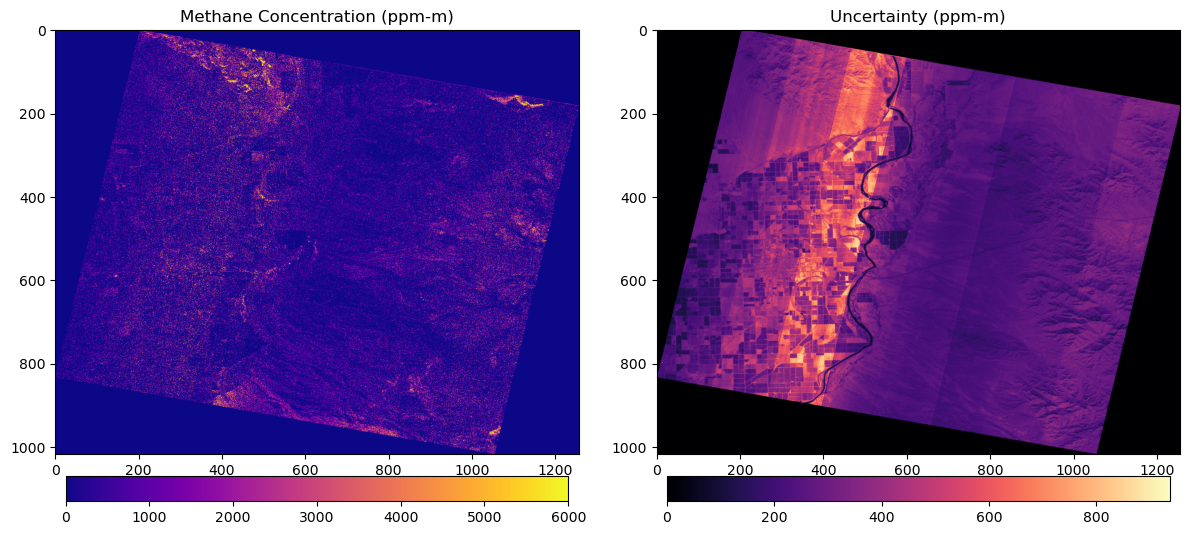

In [5]:

conc_arr, geotransform, projection, _ = plumes_analyzer.load_geotiff(str(CONCENTRATION_FILE))
unc_arr, _, _, _ = plumes_analyzer.load_geotiff(str(UNCERTAINTY_FILE))

reporter.log_block(
    'Input raster summary',
    [
        f'Concentration raster: {CONCENTRATION_FILE.name}',
        f'Uncertainty raster: {UNCERTAINTY_FILE.name}',
        f'Array shape: {conc_arr.shape}'
    ]
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

im1 = ax1.imshow(conc_arr, cmap='plasma', vmin=0, vmax=6000)
ax1.set_title('Methane Concentration (ppm-m)')
fig.colorbar(im1, ax=ax1, orientation='horizontal', fraction=0.046, pad=0.04)

im2 = ax2.imshow(unc_arr, cmap='magma')
ax2.set_title('Uncertainty (ppm-m)')
fig.colorbar(im2, ax=ax2, orientation='horizontal', fraction=0.046, pad=0.04)

plt.tight_layout()
reporter.log_figure('Scene-wide concentration and uncertainty', fig)
plt.show()


## 4. Load the Segmented Plume Polygons

The matched filter pipeline may produce multiple plume polygons. We load the shapefile, project it to a local UTM CRS for area measurements, and prepare a record for each plume that will be analyzed in the following steps.

Plume polygon summary
Loaded 1 plume polygon(s) from plume_hygas_full_column.shp
Shapefile CRS: EPSG:4326
Raster CRS for clipping: EPSG:4326
Projected CRS for area calculations: EPSG:32611



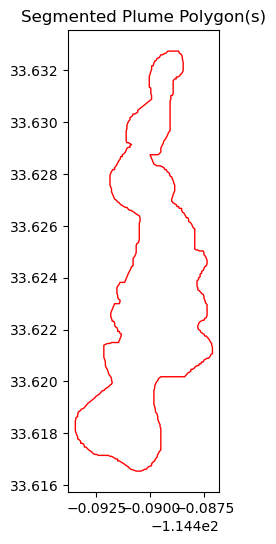

In [6]:
if not SHAPEFILE_PATH.exists():
    raise FileNotFoundError(f'Plume shapefile not found: {SHAPEFILE_PATH}')

gdf = gpd.read_file(SHAPEFILE_PATH)
_, _, raster_wkt, _ = plumes_analyzer.load_geotiff(str(CONCENTRATION_FILE))
raster_crs = CRS.from_wkt(raster_wkt)
gdf_raster = gdf.to_crs(raster_crs)
projected_gdf, projected_epsg = plumes_analyzer.project_gdf_to_local_utm(gdf)

plume_records = []
for (idx, row), (_, proj_row), (_, raster_row) in zip(gdf.iterrows(), projected_gdf.iterrows(), gdf_raster.iterrows()):
    plume_records.append({
        'plume_id': idx,
        'geom': row.geometry,
        'geom_raster': raster_row.geometry,
        'projected_geom': proj_row.geometry
    })

summary_lines = [
    f'Loaded {len(plume_records)} plume polygon(s) from {SHAPEFILE_PATH.name}',
    f'Shapefile CRS: {gdf.crs}',
    f'Raster CRS for clipping: {raster_crs.to_string()}',
    f'Projected CRS for area calculations: EPSG:{projected_epsg}'
]
reporter.log_block('Plume polygon summary', summary_lines)

ax = gdf.plot(edgecolor='red', facecolor='none', figsize=(6, 6))
ax.set_title('Segmented Plume Polygon(s)')
fig = ax.get_figure()
reporter.log_figure('Segmented plume polygon(s)', fig)
plt.show()


## 5. Unit Conversion

The input data is in `ppm-m` (parts per million-meter), but the IME calculation requires `ppb` (parts per billion). We convert the concentration and uncertainty values from `ppm-m` to `ppb` once here, and these arrays serve as the starting point for every plume-specific calculation.


In [7]:

conc_clean = plumes_analyzer.discard_neg(conc_arr)
unc_clean = plumes_analyzer.discard_neg(unc_arr)

conc_ppb = plumes_analyzer.ppm_m_to_ppb(conc_clean)
unc_ppb = plumes_analyzer.ppm_m_to_ppb(unc_clean)

reporter.log_block(
    'PPB conversion overview',
    [
        f'Original max concentration: {np.max(conc_arr):.2f} ppm-m',
        f'Converted max concentration: {np.max(conc_ppb):.2f} ppb'
    ]
)


PPB conversion overview
Original max concentration: 16272.51 ppm-m
Converted max concentration: 2034.06 ppb



## 6. Clipping the Rasters for Each Plume

For each polygon in the plume mask we clip the concentration and uncertainty rasters, keeping only positive values. This yields one pair of maps per plume that we will use for statistics, IME, and flux estimates.


Plume 0 clipped rasters
Concentration raster saved to clipped_conc_plume_0.tif
Uncertainty raster saved to clipped_unc_plume_0.tif
Positive concentration pixels: 347



/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:9374: RuntimeWarning: the source raster dataset has a SRS, but the cutline features not.  We assume that the cutline coordinates are expressed in the destination SRS. If not, cutline results may be incorrect.
  return _gdal.wrapper_GDALWarpDestName(*args)


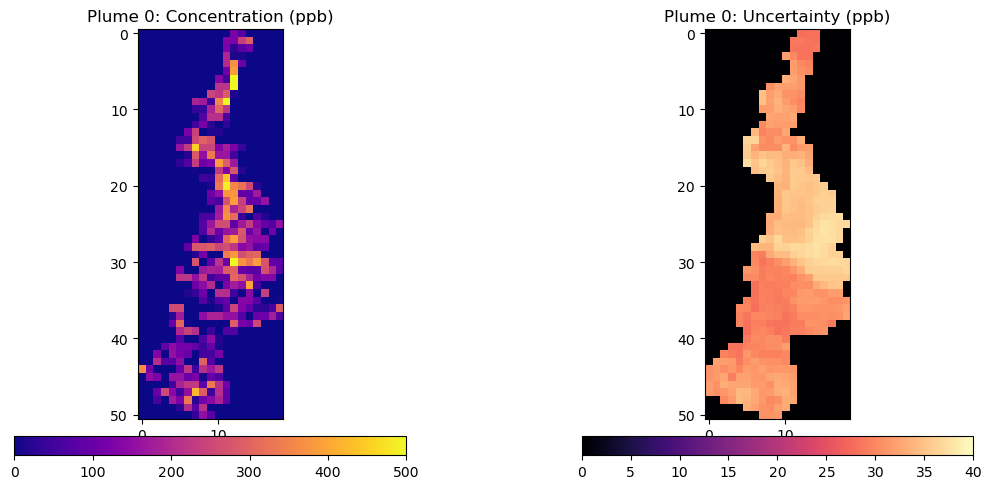

In [8]:
plume_outputs = []
for record in plume_records:
    plume_id = record['plume_id']
    conc_out = OUTPUT_DIR / f'clipped_conc_plume_{plume_id}.tif'
    unc_out = OUTPUT_DIR / f'clipped_unc_plume_{plume_id}.tif'
    clip_geom = record['geom_raster']
    clipped_conc_arr = plumes_analyzer.clip_raster_to_polygon(
        str(CONCENTRATION_FILE),
        clip_geom,
        str(conc_out)
    )
    clipped_conc_arr = plumes_analyzer.discard_neg(clipped_conc_arr)

    clipped_unc_arr = plumes_analyzer.clip_raster_to_polygon(
        str(UNCERTAINTY_FILE),
        clip_geom,
        str(unc_out)
    )
    clipped_unc_arr = plumes_analyzer.discard_neg(clipped_unc_arr)

    clipped_conc_ppb = plumes_analyzer.ppm_m_to_ppb(clipped_conc_arr)
    clipped_unc_ppb = plumes_analyzer.ppm_m_to_ppb(clipped_unc_arr)
    plume_stats = plumes_analyzer.compute_plume_stats(clipped_conc_ppb)

    plume_outputs.append({
        'plume_id': plume_id,
        'geom': record['geom'],
        'geom_raster': clip_geom,
        'projected_geom': record['projected_geom'],
        'clipped_conc_ppb': clipped_conc_ppb,
        'clipped_unc_ppb': clipped_unc_ppb,
        'plume_stats': plume_stats
    })

    positive_pixels = int(np.count_nonzero(clipped_conc_ppb))
    reporter.log_block(
        f'Plume {plume_id} clipped rasters',
        [
            f'Concentration raster saved to {conc_out.name}',
            f'Uncertainty raster saved to {unc_out.name}',
            f'Positive concentration pixels: {positive_pixels}'
        ]
    )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    im1 = ax1.imshow(clipped_conc_ppb, cmap='plasma', vmin=0, vmax=500)
    ax1.set_title(f'Plume {plume_id}: Concentration (ppb)')
    fig.colorbar(im1, ax=ax1, orientation='horizontal', fraction=0.046, pad=0.04)

    im2 = ax2.imshow(clipped_unc_ppb, cmap='magma', vmin=0, vmax=40)
    ax2.set_title(f'Plume {plume_id}: Uncertainty (ppb)')
    fig.colorbar(im2, ax=ax2, orientation='horizontal', fraction=0.046, pad=0.04)

    plt.tight_layout()
    reporter.log_figure(f'Plume {plume_id} clipped rasters', fig)
    plt.show()


### Plume concentration statistics

We report descriptive statistics for each plume's positive ppb pixels.

In [9]:

for output in plume_outputs:
    stats = output['plume_stats']
    reporter.log_block(
        f"Plume {output['plume_id']} concentration statistics",
        [
            f"Positive plume pixels: {stats['pixel_count']}",
            f"Min concentration: {stats['min']:.2f} ppb",
            f"Max concentration: {stats['max']:.2f} ppb",
            f"Mean concentration: {stats['mean']:.2f} ppb",
            f"Median concentration: {stats['median']:.2f} ppb"
        ]
    )


Plume 0 concentration statistics
Positive plume pixels: 347
Min concentration: 1.45 ppb
Max concentration: 549.50 ppb
Mean concentration: 161.68 ppb
Median concentration: 141.80 ppb



## 7. Integrated Methane Enhancement (IME) Calculation

The Integrated Methane Enhancement (IME) represents the total mass of methane in a plume. For every plume we sum the concentration of all pixels within the clipped mask and multiply by a conversion factor. The formula is:

$$ IME (kg) = \sum_{i=1}^{N} (ppb_i) * k $$
where:
- $ppb_i$ is the methane concentration in ppb for pixel i.
- $N$ is the total number of pixels in the plume.
- $k$ is a conversion factor that depends on the pixel area (GSD), and the molar masses of methane and air.

The conversion factor $k$ is calculated as:

$$ k = (GSD^2) * (\frac{M_{CH4}}{M_{air}}) * 10000 * 10^{-9} $$
where:
- $GSD$ is the ground sample distance in meters.
- $M_{CH4}$ is the molar mass of methane (16.04 g/mol).
- $M_{air}$ is the molar mass of dry air (28.97 g/mol).


In [10]:
for output in plume_outputs:
    ime = plumes_analyzer.calculate_ime(output['clipped_conc_ppb'], CASE_CONFIG['gsd'])
    output['ime'] = ime
    reporter.log_block(
        f"Plume {output['plume_id']} IME",
        [
            f"Integrated Methane Enhancement (IME): {ime:.2f} kg (GSD: {CASE_CONFIG['gsd']} m)"
        ]
    )


Plume 0 IME
Integrated Methane Enhancement (IME): 279.56 kg (GSD: 30 m)



## 8. IME Uncertainty Calculation

The uncertainty of the IME is calculated by propagating the uncertainty of each pixel's concentration. Assuming the uncertainties of individual pixels are uncorrelated, the total uncertainty of the IME is the square root of the sum of the squares of the individual uncertainties, multiplied by the same conversion factor k.

$$ \sigma_{IME} (kg) = k * \sqrt{\sum_{i=1}^{N} (\sigma_{ppb,i}^2)} $$
where:
- $\sigma_{ppb,i}$ is the uncertainty of the methane concentration in ppb for pixel i.

In [11]:

for output in plume_outputs:
    sigma_ime = plumes_analyzer.calculate_sigma_ime(output['clipped_unc_ppb'], CASE_CONFIG['gsd'])
    output['sigma_ime'] = sigma_ime
    reporter.log_block(
        f"Plume {output['plume_id']} σ_IME",
        [f"IME uncertainty (σ_IME): {sigma_ime:.2f} kg"]
    )


Plume 0 σ_IME
IME uncertainty (σ_IME): 3.39 kg



## 9. Wind Response and Flux Calculation

The methane flux (Q) is the rate at which methane is emitted. For each plume we use its IME, an effective wind speed ($U_{eff}$), and the length scale ($L$) computed from the plume area. The formula is:

$$ Q (t/h) = \frac{U_{eff} * IME * 3.6}{L} $$
where:
- $U_{eff}$ is the effective wind speed in m/s.
- $IME$ is the integrated methane enhancement in kg.
- $L$ is the length scale of the plume in meters, approximated as the square root of the plume area.
- The factor 3.6 converts from kg/s to t/h.

The effective wind speed $U_{eff}$ is calculated from the wind speed at 10 meters ($U_{10}$) using a sensor-specific linear relationship. Prior to computing each area, we project the plume polygon to a local UTM CRS so measurements are in square meters.



In [12]:

for output in plume_outputs:
    area = output['projected_geom'].area
    L = math.sqrt(area)
    u_eff, a, b = plumes_analyzer.compute_u_eff(U10, SENSOR_TYPE)
    q = plumes_analyzer.compute_flux(output['ime'], u_eff, L)
    output.update({'area': area, 'L': L, 'u_eff': u_eff, 'a': a, 'b': b, 'q': q})
    reporter.log_block(
        f"Plume {output['plume_id']} area and flux",
        [
            f"Area: {area:.2f} m^2 (Projected EPSG:{projected_epsg})",
            f"Length Scale (L): {L:.2f} m",
            f"Effective Wind Speed (U_eff): {u_eff:.2f} m/s",
            f"Methane Flux (Q): {q:.2f} t/h"
        ]
    )


Plume 0 area and flux
Area: 460749.58 m^2 (Projected EPSG:32611)
Length Scale (L): 678.79 m
Effective Wind Speed (U_eff): 2.06 m/s
Methane Flux (Q): 3.05 t/h



## 10. Flux Uncertainty Propagation

The uncertainty in the flux ($\sigma_Q$) is propagated from the uncertainties in the IME ($\sigma_{IME}$) and the wind speed ($\sigma_{U10}$). The total uncertainty is the quadrature sum of the uncertainties from these two sources:

$$ \sigma_Q = \sqrt{\sigma_{Q,IME}^2 + \sigma_{Q,wind}^2} $$
where:
- $\sigma_{Q,IME} = Q * (\frac{\sigma_{IME}}{IME})$ is the flux uncertainty due to IME uncertainty.
- $\sigma_{Q,wind} = Q * (\frac{\sigma_{Ueff}}{U_{eff}})$ is the flux uncertainty due to wind uncertainty.

The uncertainty in the effective wind speed is given by:

$$ \sigma_{Ueff} = |a| * \sigma_{U10} $$


In [13]:

for output in plume_outputs:
    sigma_q, sigma_q_ime, sigma_q_wind = plumes_analyzer.propagate_flux_uncertainty(
        output['q'],
        output['ime'],
        output['sigma_ime'],
        U10,
        SIGMA_U10,
        output['u_eff'],
        output['a']
    )
    output.update({
        'sigma_q': sigma_q,
        'sigma_q_ime': sigma_q_ime,
        'sigma_q_wind': sigma_q_wind
    })
    reporter.log_block(
        f"Plume {output['plume_id']} flux uncertainty",
        [
            f"Total Flux Uncertainty (σ_Q): ±{sigma_q:.2f} t/h",
            f"Flux Uncertainty from IME: {sigma_q_ime:.2f} t/h",
            f"Flux Uncertainty from Wind: {sigma_q_wind:.2f} t/h"
        ]
    )


Plume 0 flux uncertainty
Total Flux Uncertainty (σ_Q): ±0.55 t/h
Flux Uncertainty from IME: 0.04 t/h
Flux Uncertainty from Wind: 0.55 t/h



## 11. Summary of Results

We now summarize the per-plume metrics (IME, flux, uncertainties, and ppb statistics) so every plume in the shapefile is reported separately.


In [14]:

for output in plume_outputs:
    stats = output['plume_stats']
    reporter.log_block(
        f"Plume {output['plume_id']} summary",
        [
            f"Plume Area: {output['area']:.2f} m^2",
            f"Plume Length Scale (L): {output['L']:.2f} m",
            f"Wind Speed (U10): {U10:.2f} ± {SIGMA_U10:.2f} m/s",
            f"Effective Wind Speed (U_eff): {output['u_eff']:.2f} m/s",
            f"Integrated Methane Enhancement (IME): {output['ime']:.2f} ± {output['sigma_ime']:.2f} kg",
            f"Methane Flux (Q): {output['q']:.2f} ± {output['sigma_q']:.2f} t/h",
            f"Flux Uncertainty from IME: {output['sigma_q_ime']:.2f} t/h",
            f"Flux Uncertainty from Wind: {output['sigma_q_wind']:.2f} t/h",
            f"Positive Pixels: {stats['pixel_count']}",
            f"Min/Max (ppb): {stats['min']:.2f} / {stats['max']:.2f}",
            f"Mean/Median (ppb): {stats['mean']:.2f} / {stats['median']:.2f}"
        ]
    )


Plume 0 summary
Plume Area: 460749.58 m^2
Plume Length Scale (L): 678.79 m
Wind Speed (U10): 3.70 ± 1.00 m/s
Effective Wind Speed (U_eff): 2.06 m/s
Integrated Methane Enhancement (IME): 279.56 ± 3.39 kg
Methane Flux (Q): 3.05 ± 0.55 t/h
Flux Uncertainty from IME: 0.04 t/h
Flux Uncertainty from Wind: 0.55 t/h
Positive Pixels: 347
Min/Max (ppb): 1.45 / 549.50
Mean/Median (ppb): 161.68 / 141.80



In [15]:

reporter.save()


Run report saved to /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/plume_analysis_walkthrough/Ehrenberg_validation_prisma/plume_analysis_run_report.md
